In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
from itertools import cycle

In [17]:
# Set random seed for reproducibility
np.random.seed(42)

In [18]:
# 1. Load and prepare data
df = pd.read_csv('../Preprocessing/balanced_ecg_data.csv')  # Your balanced dataset
print("Dataset Head:\n", df.head())
print("\nClass Distribution:\n", df['target'].value_counts())

Dataset Head:
    Feature1  Feature2  Feature3  Feature4  Feature5  Feature6  Feature7  \
0 -1.944044  1.891310  5.378017 -1.099764  0.319998 -0.107990  0.192998   
1  0.548890  3.689146 -1.079215 -1.125497  6.892610 -0.114086 -0.129833   
2  1.044743  2.804073 -1.779122 -0.358211  6.132624 -1.309396 -0.731316   
3 -2.848743 -2.220174 -0.498797 -0.054547  0.073406  0.927517  1.891807   
4 -0.715628  0.217362  2.032461 -0.144826  4.375660 -1.762026  1.335940   

   Feature8  Feature9  Feature10  ...  Feature21  Feature22  Feature23  \
0 -0.531588 -1.978358   0.505306  ...   0.435838  -0.375777  -2.410484   
1 -4.471123  1.281707   2.509007  ...  -0.515136  -1.814937  -0.659753   
2 -3.381683 -1.444734   3.028355  ...  -0.928873  -1.592203  -0.389953   
3 -0.381548  0.017551   0.659493  ...   0.662054   0.671306  -0.463003   
4  1.742721 -1.771379   0.819612  ...  -0.428352  -0.511074  -0.346423   

   Feature24  Feature25  Feature26  Feature27  Feature28  Feature29  target  
0   1.30730

In [19]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

In [20]:
# 2. Split data (stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,
    stratify=y  # Preserve class distribution
)

In [21]:
# 3. Feature scaling (essential for K-means)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 4. Initialize and train KMeans Clustering model
kmeans = KMeans(
    n_clusters=15,        # 15 clusters (assuming 15 classes)
    init='k-means++',     # Smart centroid initialization
    max_iter=300,         # Ensures convergence
    random_state=42,      # Reproducibility
    n_init=10             # Number of times k-means runs with different centroid seeds
)   

In [23]:
# Fit K-means on training data and predict clusters on test data
kmeans.fit(X_train_scaled)
y_pred_train = kmeans.predict(X_train_scaled)
y_pred_test = kmeans.predict(X_test_scaled)

In [24]:
# 5. Map K-means cluster labels to actual class labels
# Since K-means assigns arbitrary cluster labels, we need to map them to true labels
# We'll use the most frequent true label in each cluster for mapping
def map_clusters_to_labels(y_true, y_cluster):
    mapping = {}
    for cluster in range(15):  # 15 clusters
        # Find the most common true label in this cluster
        mask = (y_cluster == cluster)
        if mask.sum() > 0:  # Ensure there are samples in this cluster
            most_common = y_true[mask].mode()[0]
            mapping[cluster] = most_common
    # Map cluster predictions to true labels
    y_mapped = np.array([mapping.get(cluster, -1) for cluster in y_cluster])
    return y_mapped

# Map clusters to true labels for test set
y_pred_mapped = map_clusters_to_labels(y_test, y_pred_test)


Classification Report:

              precision    recall  f1-score   support

     Class 0       1.00      0.05      0.10       110
     Class 1       0.00      0.00      0.00       110
     Class 2       0.43      0.36      0.39       110
     Class 3       0.31      0.73      0.44       111
     Class 4       0.95      1.00      0.97       110
     Class 5       0.95      1.00      0.97       110
     Class 6       0.97      1.00      0.98       111
     Class 7       0.28      0.56      0.37       110
     Class 8       0.00      0.00      0.00       110
     Class 9       0.53      1.00      0.69       110
    Class 10       0.82      1.00      0.90       110
    Class 11       0.67      1.00      0.81       110
    Class 12       1.00      1.00      1.00       110
    Class 13       0.76      0.75      0.76       110
    Class 14       0.00      0.00      0.00       110

    accuracy                           0.63      1652
   macro avg       0.58      0.63      0.56      1652
w

c:\Users\Sriharish\Miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Sriharish\Miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Sriharish\Miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


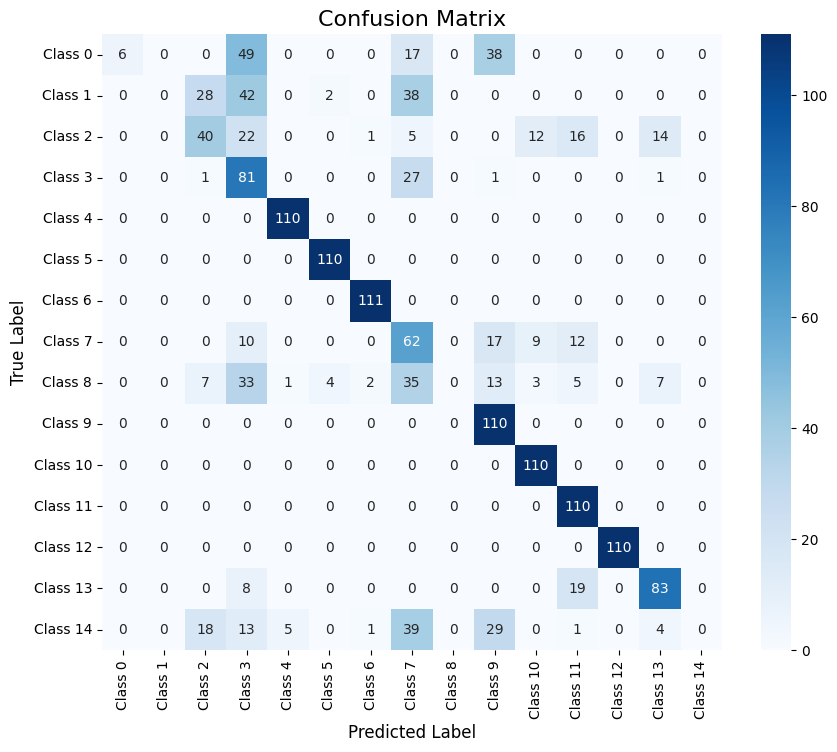

In [25]:
# 6. Evaluation Metrics
# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_mapped, target_names=[f"Class {i}" for i in range(15)]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_mapped)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f"Class {i}" for i in range(15)],
            yticklabels=[f"Class {i}" for i in range(15)])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

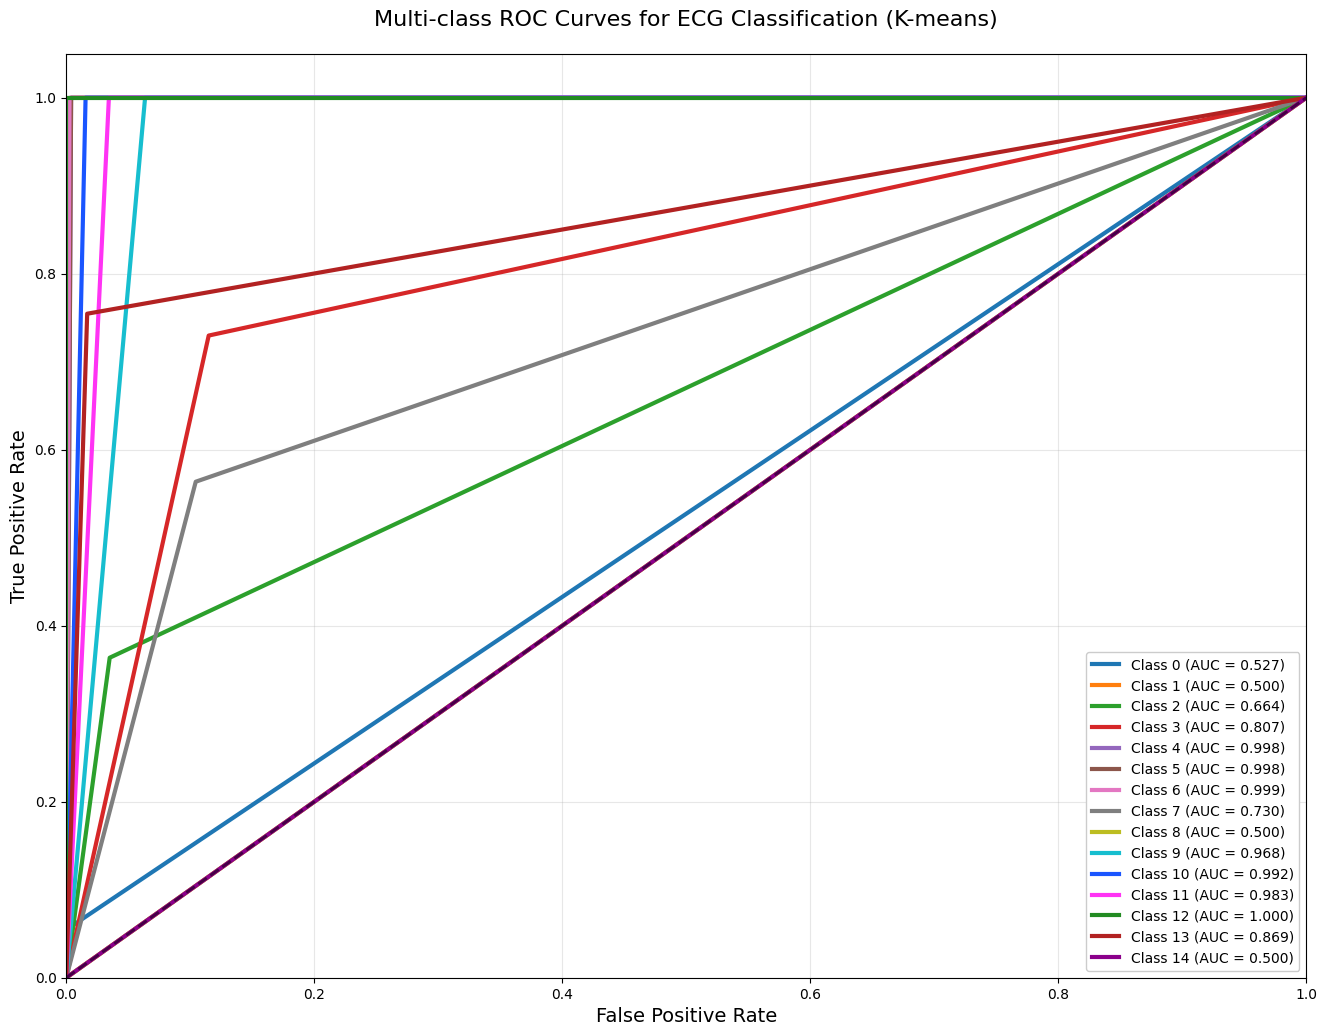

In [26]:
# 7. ROC Curves for All Classes
# Binarize the true and predicted labels for ROC calculation
y_test_bin = label_binarize(y_test, classes=range(15))
y_pred_bin = label_binarize(y_pred_mapped, classes=range(15))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(15):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(16, 12))
colors = cycle([
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#1a55FF', '#FF33F4', '#228B22', '#B22222', '#8B008B'
])

for i, color in zip(range(15), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=3,
             label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

# Formatting
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-class ROC Curves for ECG Classification (K-means)', fontsize=16, pad=20)
plt.legend(loc='lower right', fontsize=10, framealpha=1)
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize

# Load your dataset (replace with your actual data loading)
# Example: Assuming a DataFrame 'df' with features and a 'target' column
df = pd.read_csv('../Preprocessing/balanced_ecg_data.csv')
X = df.drop('target', axis=1)
y = df['target']


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit K-means on the training data
kmeans = KMeans(
    n_clusters=15,           # Number of clusters matches number of classes
    init='k-means++',        # Smart initialization
    n_init=10,               # Number of initializations
    random_state=42          # For reproducibility
)
kmeans.fit(X_train_scaled)

# Predict cluster labels for training and test data
y_pred_train = kmeans.predict(X_train_scaled)
y_pred_test = kmeans.predict(X_test_scaled)

# Define a function to map clusters to true labels using training data
def map_clusters_to_labels(y_true_train, y_pred_train):
    """
    Maps each cluster to the most frequent true label in the training data.
    
    Parameters:
    - y_true_train: True labels of the training data (array-like)
    - y_pred_train: Predicted cluster labels for the training data (array-like)
    
    Returns:
    - mapping: Dictionary mapping cluster indices to true labels
    """
    mapping = {}
    y_true_train = pd.Series(y_true_train)  # Convert to Series for mode()
    for cluster in range(15):  # Assuming 15 clusters
        mask = (y_pred_train == cluster)
        if mask.sum() > 0:  # Check if the cluster has any samples
            most_common = y_true_train[mask].mode()[0]  # Most frequent label
            mapping[cluster] = most_common
        else:
            mapping[cluster] = -1  # Default value (unlikely with K-means on training data)
    return mapping

# Create the mapping from training data
mapping = map_clusters_to_labels(y_train, y_pred_train)

# Apply the mapping to test predictions
y_pred_mapped = np.array([mapping[cluster] for cluster in y_pred_test])

# Evaluate the model
## Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_mapped)
print(f"\nAccuracy: {accuracy * 100:.2f}%\n")

## Generate and print classification report
print("Classification Report:\n")
print(classification_report(
    y_test,
    y_pred_mapped,
    target_names=[f"Class {i}" for i in range(15)]
))

## Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_mapped)
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[f"Class {i}" for i in range(15)],
    yticklabels=[f"Class {i}" for i in range(15)]
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Optional: Plot ROC curves for each class
y_test_bin = label_binarize(y_test, classes=range(15))
y_pred_bin = label_binarize(y_pred_mapped, classes=range(15))

from sklearn.metrics import roc_curve, auc
fpr = {}
tpr = {}
roc_auc = {}
for i in range(15):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(15):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()